In [1]:
# Standard python code
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c
from scipy.special import fresnel
import sys
sys.path.insert(0,"../")
# huntstone imports

from plotting import makefig
import prop_plasma as pp
from read_data import read_data
from v_x_interp import velocity_interp, position_interp


# Plotting style
plt.style.use('huntstone')
# Set parameters for reading WARGSim dumps
path   = "/media/keenan/Data_Storage/WARGSim/500dumps/"
N      = int(1e6)
nDumps = 500

beam_params = {
    'N'       : int(1e6),
    'beamE'   : 10e9, 
    'eps_n0'  : 3.0e-6,
    'beta0'   : [0.25, 0.25], 
    'alpha0'  : [0.00, 0.00],
    'rms_z'  : 0.00,
    'rms_gb0' : 0.01,
    'path'    : '/media/keenan/Data_Storage/WARGSim/',
    'B_mag'   : 5.00
}
plasma_params = {
    'n0'    : 0.34,
    'L_ft'  : 0.4,
    'hw_up' : 0.0,
    'shape' : 'Gauss'
}
my_ebeam = pp.init_beam(beam_params, plasma_params['n0'])
pwfa0    = pp.init_plasma(beam_params, plasma_params)
dumpPeriod = int(len(pwfa0.dz) / nDumps)

beta factor = 43.83
Bmag = 21.92
init eps_nx =  3.0046113028143224e-06
init eps_ny =  2.999783168036765e-06


In [2]:
x = np.load("x_test.npy")
y = np.load("y_test.npy")
gb = np.load("gb_test.npy")
z = np.linspace(0, pwfa0.L, nDumps)
t = z / c

In [3]:
# Calculate proper time
dtau = np.diff(t)[0]/gb
tau  = np.zeros(nDumps)
for i in range(1, nDumps):
    tau[i] = tau[i-1] + dtau[i-1]

In [4]:
# Interp 4-position
tau_int = np.linspace(tau[0], tau[-1], 1000)
ct1n, ct2n, ct_int = position_interp(c*t, tau, tau_int)
x1n, x2n, x_int = position_interp(x, tau, tau_int)
y1n, y2n, y_int = position_interp(y, tau, tau_int)
z1n, z2n, z_int = position_interp(z, tau, tau_int)
x0  = (c*t, x, y, z)
x1n = (ct1n, x1n, y1n, z1n)
x2n = (ct2n, x2n, y2n, z2n)

In [5]:
vx  = np.diff(x) / np.diff(tau)
vx  = np.append(vx, vx[-1])
vy  = np.diff(y) / np.diff(tau)
vy  = np.append(vy, vy[-1])
vz  = np.diff(z) / np.diff(tau)
vz  = np.append(vz, vz[-1])
vct = c * gb 

In [6]:
vx1n, vx_int = velocity_interp(vx, tau, tau_int)
vy1n, vy_int = velocity_interp(vy, tau, tau_int)
vz1n, vz_int = velocity_interp(vz, tau, tau_int)
vct1n, vct_int = velocity_interp(vct, tau, tau_int)

In [7]:
A      = 1
kap    = A * np.array([A, A/2, A/2, A/np.sqrt(2)])
chi_1n = kap[0] * x1n[0] - kap[1] * x1n[1] - kap[2] * x1n[2] - kap[3] * x1n[3]
chi_2n = kap[0] * x2n[0] - kap[1] * x2n[1] - kap[2] * x2n[2] - kap[3] * x2n[3]

In [8]:
ind = np.argwhere(chi_2n >0)
chi_1n = chi_1n[ind]
chi_2n = chi_2n[ind]
dtau   = dtau[ind]
vx     = vx[ind]
vy     = vy[ind]
vz     = vz[ind]
vx1n   = vx1n[ind]
vy1n   = vy1n[ind]
vz1n   = vz1n[ind]

In [9]:
phi_p  = (dtau**2 * chi_2n / 4) + (dtau * chi_1n / 2)
phi_m  = phi_p = (dtau**2 * chi_2n / 4) + (dtau * chi_1n / 2)
theta_p = (chi_1n + chi_2n * dtau) / np.sqrt(2 * np.pi * chi_2n)
theta_m = (chi_1n - chi_2n * dtau) / np.sqrt(2 * np.pi * chi_2n)

In [10]:
psi_p_x = np.sqrt(2 * np.pi / chi_2n) * (2 * chi_2n * vx - chi_1n * vx1n) * np.cos(chi_1n**2 / 4 * chi_2n)
psi_p_y = np.sqrt(2 * np.pi / chi_2n) * (2 * chi_2n * vy - chi_1n * vy1n) * np.cos(chi_1n**2 / 4 * chi_2n)
psi_p_z = np.sqrt(2 * np.pi / chi_2n) * (2 * chi_2n * vz - chi_1n * vz1n) * np.cos(chi_1n**2 / 4 * chi_2n)

In [11]:
psi_m_x = np.sqrt(2 * np.pi / chi_2n) * (2 * chi_2n * vx - chi_1n * vx1n) * np.sin(chi_1n**2 / 4 * chi_2n)
psi_m_y = np.sqrt(2 * np.pi / chi_2n) * (2 * chi_2n * vy - chi_1n * vy1n) * np.sin(chi_1n**2 / 4 * chi_2n)
psi_m_z = np.sqrt(2 * np.pi / chi_2n) * (2 * chi_2n * vz - chi_1n * vz1n) * np.sin(chi_1n**2 / 4 * chi_2n)

In [12]:
f_ind = np.argwhere(dtau * chi_2n >= 0.1)
t_ind = np.argwhere(dtau * chi_2n > 0.1)
RIx   = np.zeros(len(chi_2n))
RIy   = np.zeros(len(chi_2n))
RIz   = np.zeros(len(chi_2n))
ImIx  = np.zeros(len(chi_2n))
ImIy  = np.zeros(len(chi_2n))
ImIz  = np.zeros(len(chi_2n))

In [17]:
def get_real_fres(chi_2n, theta_p, theta_m, psi_p, psi_m, v1, phi_p, phi_m):
    Sp, Cp = fresnel(theta_p)
    Sm, Cm = fresnel(theta_m)
    t1     = psi_p * (Cp - Cm)
    t2     = psi_m * (Sp - Sm)
    t3     = 2 * v1 * (np.sin(phi_p) - np.sin(phi_m))
    Re     = (1 / np.sqrt(4 * chi_2n)) * (t1 + t2 + t3)
    return Re

def get_real_taylor(v0, dtau, chi_1n):
    return v0 * np.sinc(chi_1n * dtau / 2)*dtau


def get_imag_fres(chi_2n, theta_p, theta_m, psi_p, psi_m, v1, phi_p, phi_m):
    Sp, Cp = fresnel(theta_p)
    Sm, Cm = fresnel(theta_m)
    t1     = psi_p * (Sp - Sm)
    t2     = psi_m * (Cp - Cm)
    t3     = 2 * v1 * (np.cos(phi_p) - np.cos(phi_m))
    Im     = (1 / np.sqrt(4 * chi_2n)) * (t1 - t2 - t3)
    return Im

def get_imag_taylor(v0, v1, chi_1n, chi_2n, dtau):
    I1 = (dtau / chi_1n) * (np.sinc(chi_1n * dtau / 2) - np.cos(chi_1n * dtau / 2))
    I2 = (dtau**3 / 4) * np.sinc(chi_1n * dtau / 2) - (2 / chi_1n) * I1
    return v1 * I1 + chi_2n * v0 * I2

In [15]:
RIx[f_ind] = get_real_fres(chi_2n, theta_p, theta_m, psi_p_x, psi_m_x, vx1n, phi_p, phi_m)
RIx[t_ind] = get_real_taylor(vx, dtau, chi_1n)
RIy[f_ind] = get_real_fres(chi_2n, theta_p, theta_m, psi_p_y, psi_m_y, vy1n, phi_p, phi_m)
RIy[t_ind] = get_real_taylor(vy, dtau, chi_1n)
RIz[f_ind] = get_real_fres(chi_2n, theta_p, theta_m, psi_p_z, psi_m_z, vz1n, phi_p, phi_m)
RIz[t_ind] = get_real_taylor(vz, dtau, chi_1n)

In [18]:
ImIx[f_ind] = get_imag_fres(chi_2n, theta_p, theta_m, psi_p_x, psi_m_x, vx1n, phi_p, phi_m)
ImIx[t_ind] = get_imag_taylor(vx, vx1n, chi_1n, chi_2n, dtau)
ImIy[f_ind] = get_imag_fres(chi_2n, theta_p, theta_m, psi_p_y, psi_m_y, vy1n, phi_p, phi_m)
ImIy[t_ind] = get_imag_taylor(vy, vy1n, chi_1n, chi_2n, dtau)
ImIz[f_ind] = get_imag_fres(chi_2n, theta_p, theta_m, psi_p_z, psi_m_z, vz1n, phi_p, phi_m)
ImIz[t_ind] = get_imag_taylor(vz, vz1n, chi_1n, chi_2n, dtau)

In [19]:
Ix = RIx + 1j * ImIx
Iy = RIy + 1j * ImIy
Iz = RIz + 1j * ImIz

In [28]:
sx = 0.5; sy = 0.5; sz = 1/np.sqrt(2)
Cx = sy * Iz - sz * Ix
Cy = sz * Ix - sx * Iz
Cz = sx * Iy - sy * Ix

In [32]:
Cx_sum = np.sum(Cx)
Cy_sum = np.sum(Cy)
Cz_sum = np.sum(Cz)
C2     = np.abs(Cx_sum)**2 + np.abs(Cy_sum)**2 + np.abs(Cz_sum)**2

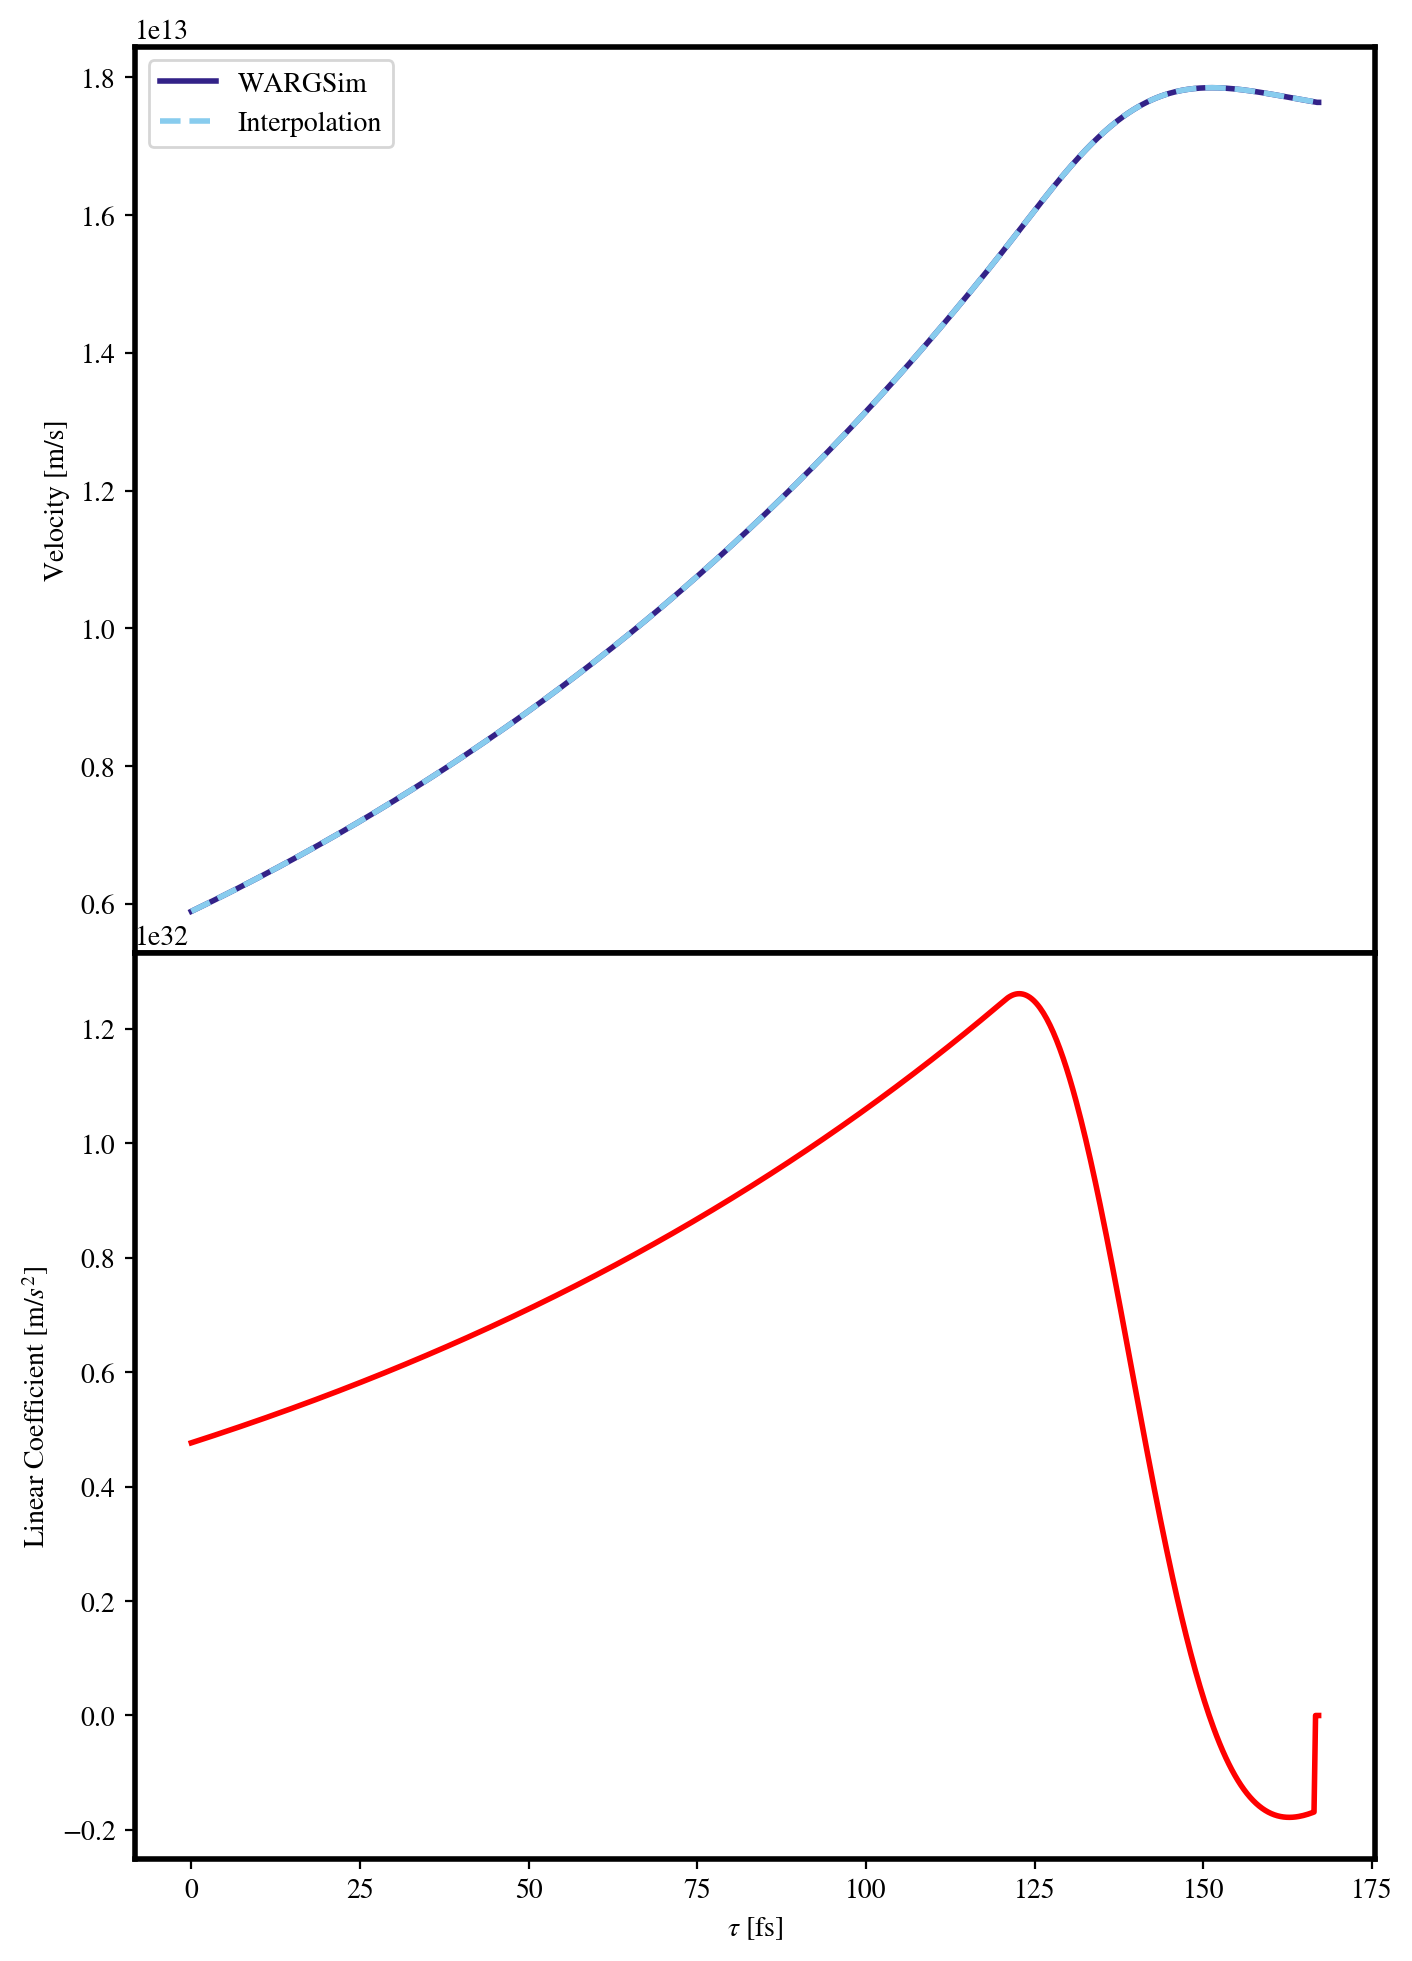

In [11]:
if True:
    v     = vz
    v_int = vz_int
    p1  = vz1n
    fig = plt.figure(figsize = (8, 12), dpi = 200)
    ax1 = fig.add_subplot(211)
    ax1.set_xticks([])
    ax1.set_ylabel(r'Velocity [m/s]')
    ax2 = fig.add_subplot(212)
    ax2.set_ylabel(r'Linear Coefficient [m/$s^2$]')
    ax2.set_xlabel(r'$\tau$ [fs]')
    plt.subplots_adjust(hspace=0)
    ax1.plot(tau*1e15, v, label = 'WARGSim')
    ax1.plot(tau_int*1e15, v_int, '--', label = 'Interpolation')
    ax1.legend()
    ax2.plot(tau*1e15, p1*1e6, color = 'r')
    plt.show()

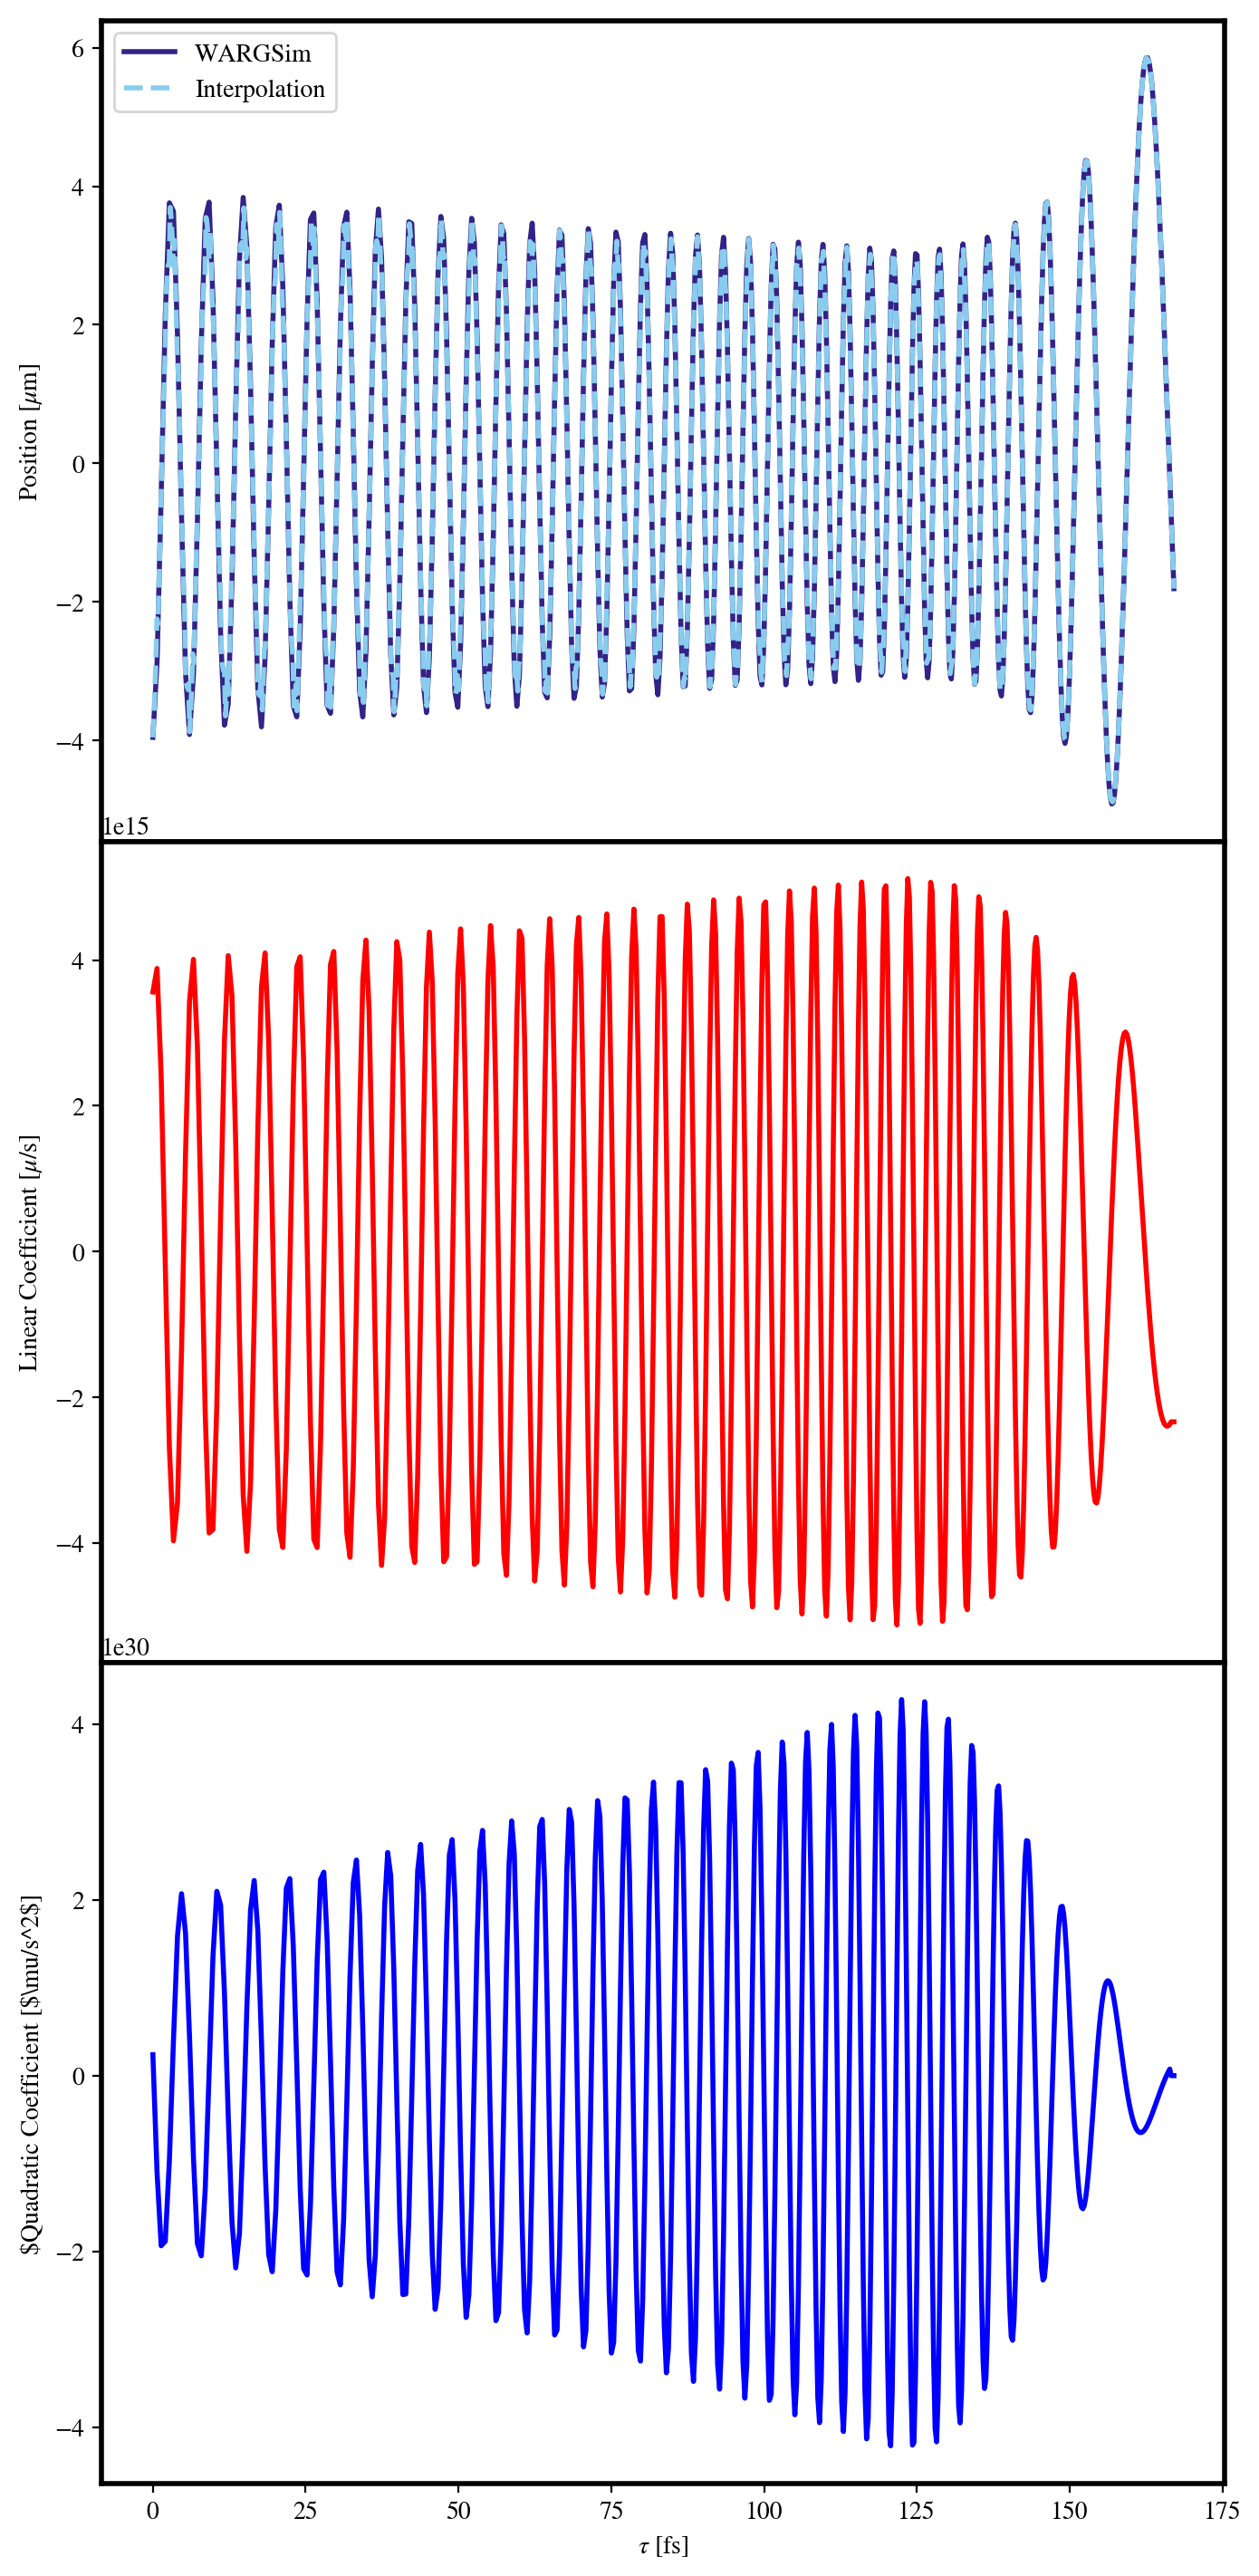

In [6]:
if True:
    pos     = x
    pos_int = x_int
    p1  = x1n
    p2  = x2n
    fig = plt.figure(figsize = (8, 18), dpi = 200)
    ax1 = fig.add_subplot(311)
    ax1.set_xticks([])
    ax1.set_ylabel(r'Position [$\mu$m]')
    ax2 = fig.add_subplot(312)
    ax2.set_xticks([])
    ax2.set_ylabel(r'Linear Coefficient [$\mu$/s]')
    ax3 = fig.add_subplot(313)
    ax3.set_xlabel(r'$\tau$ [fs]')
    ax3.set_ylabel(r'$Quadratic Coefficient [$\mu/s^2$]')
    plt.subplots_adjust(hspace=0)

    ax1.plot(tau*1e15, pos*1e6, label = 'WARGSim')
    ax1.plot(tau_int*1e15, pos_int*1e6, '--', label = 'Interpolation')
    ax1.legend()

    ax2.plot(tau*1e15, p1*1e6, color = 'r')
    ax3.plot(tau*1e15, p2*1e6, color = 'b')
    plt.show()

In [26]:
kappa   = np.array([1, 0.5, 0.5, 1/np.sqrt(2)])
x_alpha = (ct2n, x2n, y2n, z2n)
chi_2n  = kappa[0]*x_alpha[0] - kappa[1]*x_alpha[1] -kappa[2]*x_alpha[2] -kappa[3]*x_alpha[3] 

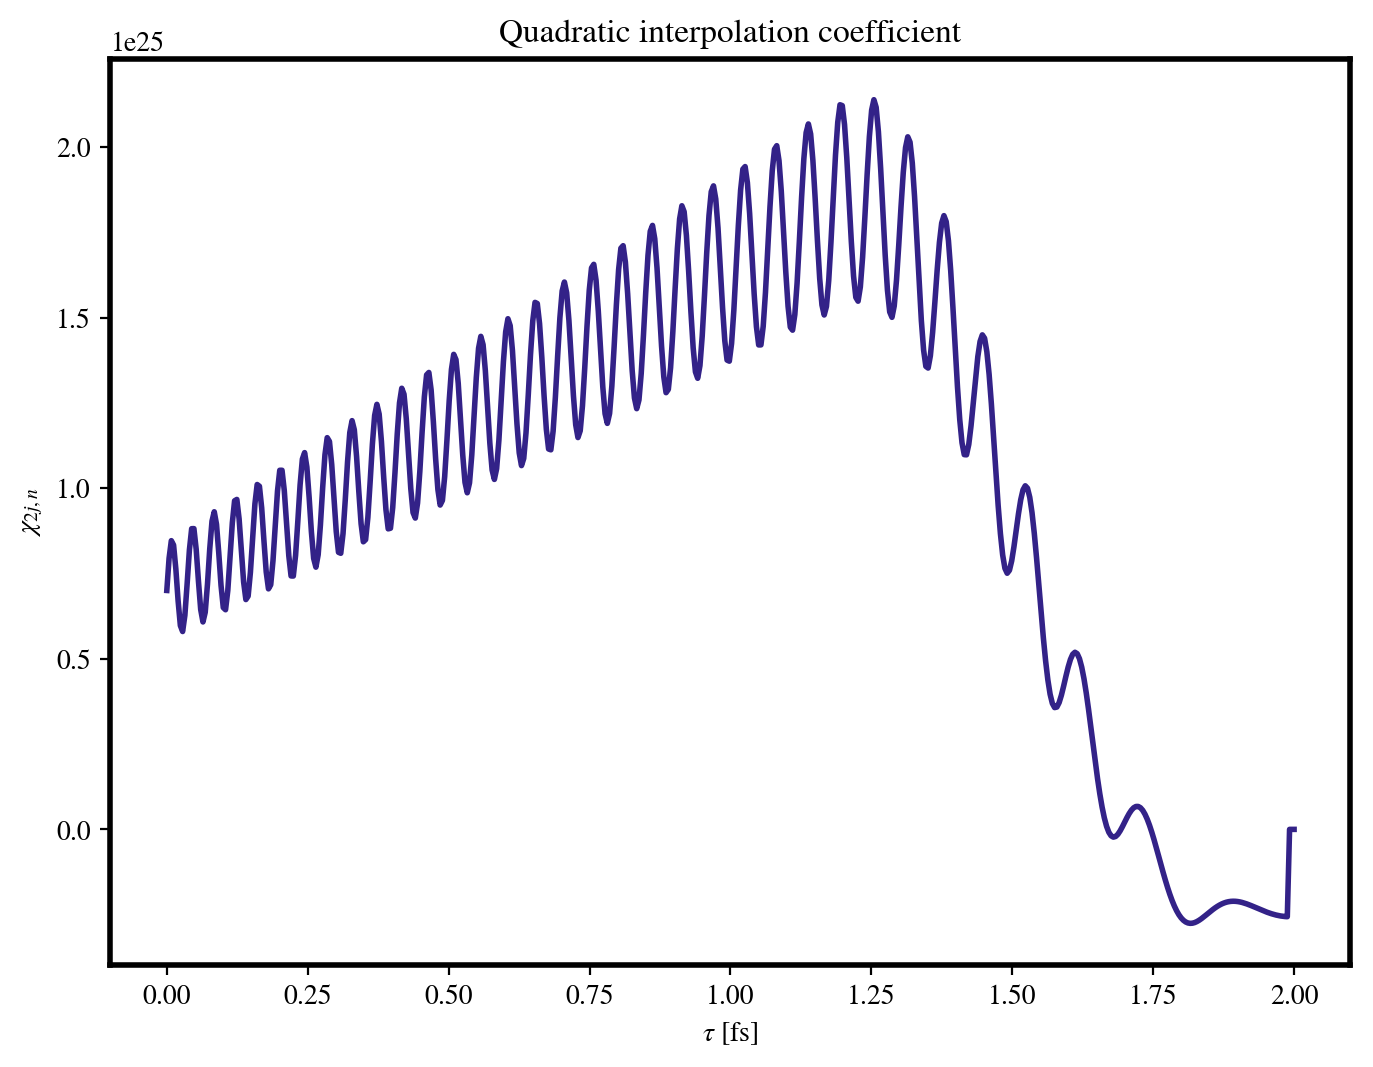

In [27]:
fig = plt.figure(figsize = (8,6), dpi = 200)
ax  = fig.gca()
ax.set_xlabel(r'$\tau$ [fs]')
ax.set_ylabel(r'$\chi_{2j,n}$')
ax.set_title('Quadratic interpolation coefficient')
#ax.axhspan(min(chi_2n), 0, color='red', alpha=0.5)
inds = np.argwhere(chi_2n > 0)
ax.plot(z, chi_2n)
plt.show()